In [ ]:
pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.9/670.9 KB 13.4 MB/s eta 0:00:00


In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from timeit import default_timer as timer

tf.random.set_seed(1234)


## Load dataset

We use the ModelNet10 model dataset, the smaller 10 class version of the ModelNet40
dataset. First download the data:


In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")


473402300/473402300 [==============================] - 13s 0us/step


We can use the `trimesh` package to read and visualize the `.off` mesh files.


In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()


To convert a mesh file to a point cloud we first need to sample points on the mesh
surface. `.sample()` performs a unifrom random sampling. Here we sample at 2048 locations
and visualize in `matplotlib`.


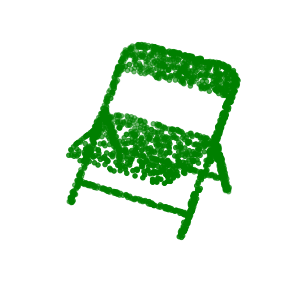

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
color = ['green']
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c = color)
ax.set_axis_off()
plt.show()


To generate a `tf.data.Dataset()` we need to first parse through the ModelNet data
folders. Each mesh is loaded and sampled into a point cloud before being added to a
standard python list and converted to a `numpy` array. We also store the current
enumerate index value as the object label and use a dictionary to recall this later.


In [ ]:
def parse_dataset(num_points=2048):  #2048

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )



Set the number of points to sample and batch size and parse the dataset. This can take
~5minutes to complete.


In [ ]:
NUM_POINTS = 2048 #1447
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)


processing class: table
processing class: monitor
processing class: dresser
processing class: chair
processing class: bed
processing class: night_stand
processing class: sofa
processing class: desk
processing class: bathtub
processing class: toilet


In [ ]:
print(train_points[0].shape)

(2048, 3)


Our data can now be read into a `tf.data.Dataset()` object. We set the shuffle buffer
size to the entire size of the dataset as prior to this the data is ordered by class.
Data augmentation is important when working with point cloud data. We create a
augmentation function to jitter and shuffle the train dataset.


In [ ]:

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels)) #train_points, train_labels test_points, test_labels
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


### Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.


In [ ]:

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)



PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). The T-net aims to learn an affine transformation matrix by its own mini
network. The T-net is used twice. The first time to transform the input features (n, 3)
into a canonical representation. The second is an affine transformation for alignment in
feature space (n, 3). As per the original paper we constrain the transformation to be
close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).


In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))



 We can then define a general function to build T-net layers.


In [ ]:

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])



The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. Here we replicate the network architecture
published in the original paper but with half the number of weights at each layer as we
are using the smaller 10 class ModelNet dataset.


In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = dense_bn(x, 8)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

### Train model

Once the model is defined it can be trained like any other standard classification model
using `.compile()` and `.fit()`.


In [ ]:
# start time
start = timer()
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)
# end time
end = timer()
print("Time taken to train the model: ",end - start)

Epoch 1/20
125/125 [==============================] - 26s 163ms/step - loss: 2.6737 - sparse_categorical_accuracy: 0.4620 - val_loss: 1458093948928.0000 - val_sparse_categorical_accuracy: 0.4306
Epoch 2/20
125/125 [==============================] - 20s 160ms/step - loss: 2.6045 - sparse_categorical_accuracy: 0.4801 - val_loss: 52738499018752.0000 - val_sparse_categorical_accuracy: 0.4207
Epoch 3/20
125/125 [==============================] - 20s 157ms/step - loss: 2.5848 - sparse_categorical_accuracy: 0.4858 - val_loss: 17664325976064.0000 - val_sparse_categorical_accuracy: 0.4714
Epoch 4/20
125/125 [==============================] - 20s 157ms/step - loss: 2.5094 - sparse_categorical_accuracy: 0.4894 - val_loss: 10649.7246 - val_sparse_categorical_accuracy: 0.4714
Epoch 5/20
125/125 [==============================] - 20s 157ms/step - loss: 2.4538 - sparse_categorical_accuracy: 0.5154 - val_loss: 259326065246208.0000 - val_sparse_categorical_accuracy: 0.5033
Epoch 6/20
125/125 [=========

In [ ]:
''' model.compile(
    loss="sparse_categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate=0.001), #'sgd',
    
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(train_dataset, epochs=25, validation_data=test_dataset)'''


' model.compile(\n    loss="sparse_categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate=0.001), #\'sgd\',\n    \n    metrics=["sparse_categorical_accuracy"],\n)\n\nhistory = model.fit(train_dataset, epochs=25, validation_data=test_dataset)'

----------------------------------

## Visualize predictions

We can use matplotlib to visualize our trained model performance.


In [ ]:
import numpy as np

1/1 [==============================] - 1s 580ms/step


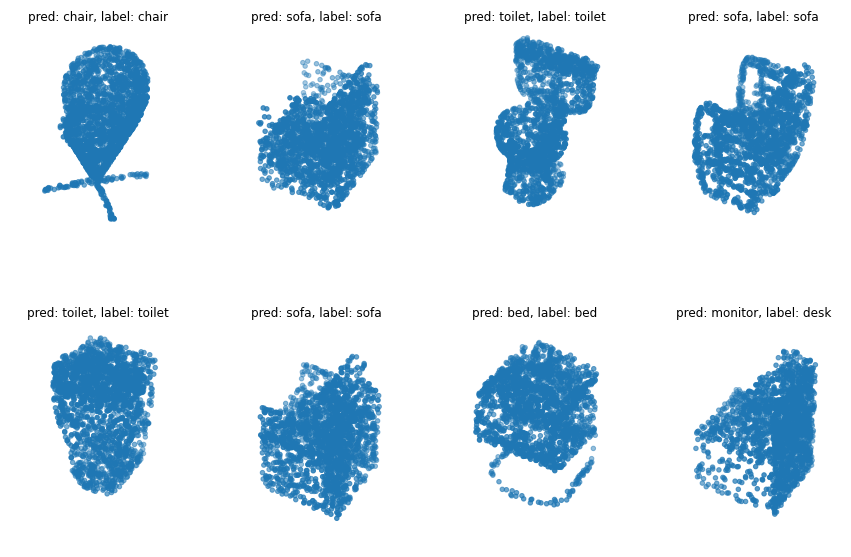

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()


In [ ]:
print(points)

[[[ 10.77901341  -4.38069266  12.125     ]
  [ -9.46288906  -2.62493209  12.125     ]
  [-11.456704   -19.34653645  12.46271085]
  ...
  [ -6.29577663 -18.327883    14.125     ]
  [ 10.14545718 -29.17544879  -6.70341727]
  [ 10.285746    12.43168501  14.125     ]]

 [[ 10.4523      12.0192659   -4.93003488]
  [ -8.00425785 -12.17251856   3.9513    ]
  [  8.02293015  15.11017      7.27670752]
  ...
  [ -1.07510198  15.11017    -10.64202591]
  [  1.85376525  15.11017    -10.57513765]
  [ 10.3385     -15.48077704  -5.46070458]]

 [[  2.14696337  -8.74581977   2.21570732]
  [ -0.91950655  -0.22615559   5.26584344]
  [ -0.99551797  -1.6437817   -2.61088622]
  ...
  [ -3.43041184   7.23985588  -1.43710381]
  [ -3.5716626    7.09669928  -4.54010472]
  [ -0.26822617  -3.82768211  -0.15555905]]

 ...

 [[ -1.0109462    5.02280125   8.78848579]
  [ -0.82769848  13.12992085   5.31999937]
  [  0.26910697 -12.81252759   7.01361183]
  ...
  [  1.88112727  -1.15065217  -4.97320821]
  [  1.71505956   

--------------------------------

In [ ]:
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.models import Model
model_feat2 = Model(inputs=model.input,outputs=model.get_layer('activation_17').output)


In [ ]:
feat_test = model_feat2.predict(test_points)

29/29 [==============================] - 1s 31ms/step


In [ ]:
print(feat_test.shape)

(908, 8)


In [ ]:
print(test_labels.shape)

(908,)


In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feat_test,test_labels, test_size=.3)


In [ ]:
print(X_train.shape)
print(y_train.shape)

(635, 8)
(635,)


# SVM (Support Vector Machine):

In [ ]:
from sklearn.svm import SVC
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
# start time
start = timer()
predtrain = svm.predict(X_train)
# end time
end = timer()
print("Time taken to predict with trained data: ",end - start)

Time taken to predict with trained data:  0.010905604999834395


In [ ]:
# start time
start = timer()
predtest = svm.predict(X_test)
# end time
end = timer()
print("Time taken to predict with test data: ",end - start)
svm.score(X_test,y_test)
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

print("Training Accuracy:",metrics.accuracy_score(predtrain,y_train))
print("Training Sensitivity:",metrics.recall_score(predtrain,y_train, average='macro'))
print("Training precision:",metrics.precision_score(predtrain,y_train, average='macro', zero_division=1))
print("Training Recall:",metrics.recall_score(predtrain,y_train, average='macro' ))
print("Training F1 Score:",f1_score(predtrain,y_train, average='macro'))

Time taken to predict with test data:  0.009652388999938921
Training Accuracy: 0.784251968503937
Training Sensitivity: 0.7993102543279871
Training precision: 0.7703854537211837
Training Recall: 0.7993102543279871
Training F1 Score: 0.7718172894058261


Confusion Matrix Plot For Train Data:


<Figure size 1080x1080 with 0 Axes>

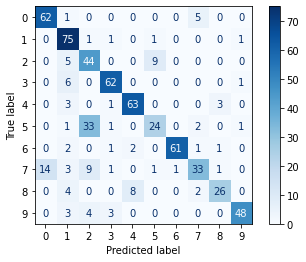

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_train, predtrain)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("Confusion Matrix Plot For Train Data:")
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print("Testing Accuracy:",metrics.accuracy_score(predtest,y_test))
print("Testing Sensitivity:",metrics.recall_score(predtest,y_test, average='macro'))
print("Testing precision:",metrics.precision_score(predtest,y_test, average='macro', zero_division=1))
print("Testing Recall:",metrics.recall_score(predtest,y_test, average='macro' ))
print("Testing F1 Score:",f1_score(predtest,y_test, average='macro'))

Testing Accuracy: 0.7142857142857143
Testing Sensitivity: 0.6945453468982881
Testing precision: 0.6797945051091966
Testing Recall: 0.6945453468982881
Testing F1 Score: 0.6746822213432903


Confusion Matrix Plot For Test Data:


<Figure size 1080x1080 with 0 Axes>

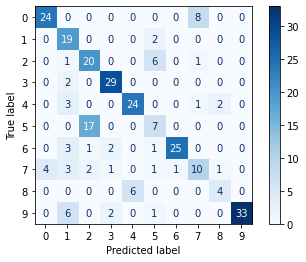

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_test, predtest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("Confusion Matrix Plot For Test Data:")
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Random Forest Classifier:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(X_train, y_train)
# start time
start = timer()
predtrain = clf.predict(X_train)
# end time
end = timer()
print("Time taken to predict with trained data: ",end - start)

Time taken to predict with trained data:  0.0173987410000791


In [ ]:
# start time
start = timer()
predtest = clf.predict(X_test)
# end time
end = timer()
print("Time taken to predict with test data: ",end - start)
svm.score(X_test,y_test)
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

print("Training Accuracy:",metrics.accuracy_score(predtrain,y_train))
print("Training Sensitivity:",metrics.recall_score(predtrain,y_train, average='macro'))
print("Training precision:",metrics.precision_score(predtrain,y_train, average='macro', zero_division=1))
print("Training Recall:",metrics.recall_score(predtrain,y_train, average='macro' ))
print("Training F1 Score:",f1_score(predtrain,y_train, average='macro'))

Time taken to predict with test data:  0.01638554600003772
Training Accuracy: 0.9937007874015747
Training Sensitivity: 0.9951807228915662
Training precision: 0.9939012444622544
Training Recall: 0.9951807228915662
Training F1 Score: 0.9944472678321554


Confusion Matrix Plot For Train Data:


<Figure size 1080x1080 with 0 Axes>

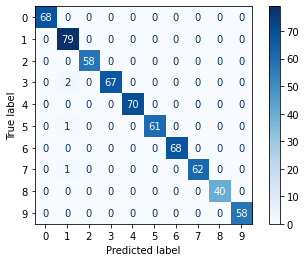

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_train, predtrain)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("Confusion Matrix Plot For Train Data:")
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print("Testing Accuracy:",metrics.accuracy_score(predtest,y_test))
print("Testing Sensitivity:",metrics.recall_score(predtest,y_test, average='macro'))
print("Testing precision:",metrics.precision_score(predtest,y_test, average='macro', zero_division=1))
print("Testing Recall:",metrics.recall_score(predtest,y_test, average='macro' ))
print("Testing F1 Score:",f1_score(predtest,y_test, average='macro'))

Testing Accuracy: 0.73992673992674
Testing Sensitivity: 0.7183307037789797
Testing precision: 0.7190492887196954
Testing Recall: 0.7183307037789797
Testing F1 Score: 0.7123907203907204


Confusion Matrix Plot For Train Data:


<Figure size 1080x1080 with 0 Axes>

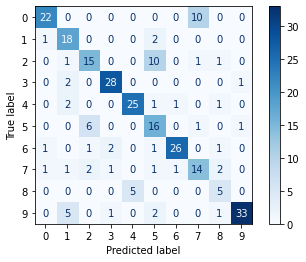

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_test, predtest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("Confusion Matrix Plot For Train Data:")
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Gradient Boosting:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
# start time
start = timer()
predtrain = gB.predict(X_train)
# end time
end = timer()
print("Time taken to predict with trained data: ",end - start)

Time taken to predict with trained data:  0.003895756000019901


In [ ]:
# start time
start = timer()
predtest = gB.predict(X_test)
# end time
end = timer()
print("Time taken to predict with test data: ",end - start)
svm.score(X_test,y_test)
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

print("Training Accuracy:",metrics.accuracy_score(predtrain,y_train))
print("Training Sensitivity:",metrics.recall_score(predtrain,y_train, average='macro'))
print("Training precision:",metrics.precision_score(predtrain,y_train, average='macro', zero_division=1))
print("Training Recall:",metrics.recall_score(predtrain,y_train, average='macro' ))
print("Training F1 Score:",f1_score(predtrain,y_train, average='macro'))

Time taken to predict with test data:  0.006996965000098498
Training Accuracy: 0.7937007874015748
Training Sensitivity: 0.7897642295699276
Training precision: 0.7932290239096041
Training Recall: 0.7897642295699276
Training F1 Score: 0.7801752668469988


Confusion Matrix Plot For Train Data:


<Figure size 1080x1080 with 0 Axes>

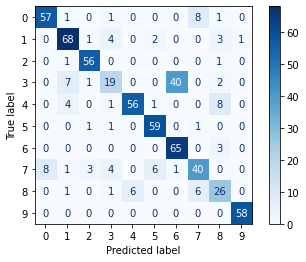

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_train, predtrain)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("Confusion Matrix Plot For Train Data:")
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print("Testing Accuracy:",metrics.accuracy_score(predtest,y_test))
print("Testing Sensitivity:",metrics.recall_score(predtest,y_test, average='macro'))
print("Testing precision:",metrics.precision_score(predtest,y_test, average='macro', zero_division=1))
print("Testing Recall:",metrics.recall_score(predtest,y_test, average='macro' ))
print("Testing F1 Score:",f1_score(predtest,y_test, average='macro'))

Testing Accuracy: 0.663003663003663
Testing Sensitivity: 0.6500309972906247
Testing precision: 0.6388069775596074
Testing Recall: 0.6500309972906247
Testing F1 Score: 0.6308312473873896


Confusion Matrix Plot For Train Data:


<Figure size 1080x1080 with 0 Axes>

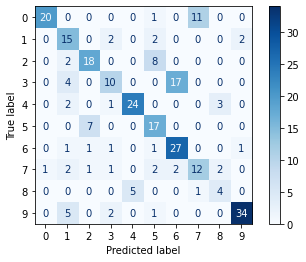

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_test, predtest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("Confusion Matrix Plot For Train Data:")
disp.plot(cmap=plt.cm.Blues)
plt.show()

# K Neighbors Classifier:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
# start time
start = timer()
predtrain = knn.predict(X_train)
# end time
end = timer()
print("Time taken to predict with trained data: ",end - start)

Time taken to predict with trained data:  0.016893774999971356


In [ ]:
# start time
start = timer()
predtest = knn.predict(X_test)
# end time
end = timer()
print("Time taken to predict with test data: ",end - start)
svm.score(X_test,y_test)
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

print("Training Accuracy:",metrics.accuracy_score(predtrain,y_train))
print("Training Sensitivity:",metrics.recall_score(predtrain,y_train, average='macro'))
print("Training precision:",metrics.precision_score(predtrain,y_train, average='macro', zero_division=1))
print("Training Recall:",metrics.recall_score(predtrain,y_train, average='macro' ))
print("Training F1 Score:",f1_score(predtrain,y_train, average='macro'))

Time taken to predict with test data:  0.010045573000070362
Training Accuracy: 0.8236220472440945
Training Sensitivity: 0.8253314353223867
Training precision: 0.8148032560805311
Training Recall: 0.8253314353223867
Training F1 Score: 0.8171226268876737


Confusion Matrix Plot For Train Data:


<Figure size 1080x1080 with 0 Axes>

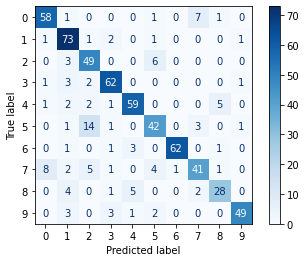

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_train, predtrain)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("Confusion Matrix Plot For Train Data:")
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print("Testing Accuracy:",metrics.accuracy_score(predtest,y_test))
print("Testing Sensitivity:",metrics.recall_score(predtest,y_test, average='macro'))
print("Testing precision:",metrics.precision_score(predtest,y_test, average='macro', zero_division=1))
print("Testing Recall:",metrics.recall_score(predtest,y_test, average='macro' ))
print("Testing F1 Score:",f1_score(predtest,y_test, average='macro'))

Testing Accuracy: 0.7362637362637363
Testing Sensitivity: 0.71526797775885
Testing precision: 0.7197349812996727
Testing Recall: 0.71526797775885
Testing F1 Score: 0.7094496146533312


Confusion Matrix Plot For Train Data:


<Figure size 1080x1080 with 0 Axes>

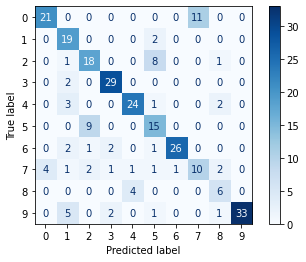

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_test, predtest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("Confusion Matrix Plot For Train Data:")
disp.plot(cmap=plt.cm.Blues)
plt.show()

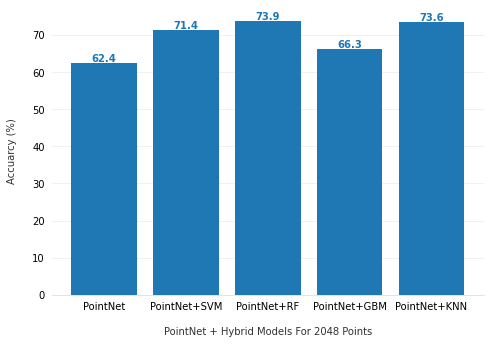

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
hModel = ['PointNet','PointNet+SVM', 'PointNet+RF', 'PointNet+GBM', 'PointNet+KNN']
acc = [62.4,71.4,73.9,66.3,73.6]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bars = ax.bar(hModel,acc)

bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )
ax.set_xlabel('PointNet + Hybrid Models For 2048 Points', labelpad=15, color='#333333')
ax.set_ylabel('Accuarcy (%)', labelpad=15, color='#333333')
#ax.set_title('Average MPG in Cars [1970-1982]', pad=15, color='#333333',
#             weight='bold')
plt.show()

image_format = 'png' # e.g .png, .svg, etc.+
image_name = 'PointNet2048.png'
fig.savefig(image_name, format=image_format, transparent=True, bbox_inches = 'tight', dpi=1200)

----------------------------

1/1 [==============================] - 0s 18ms/step


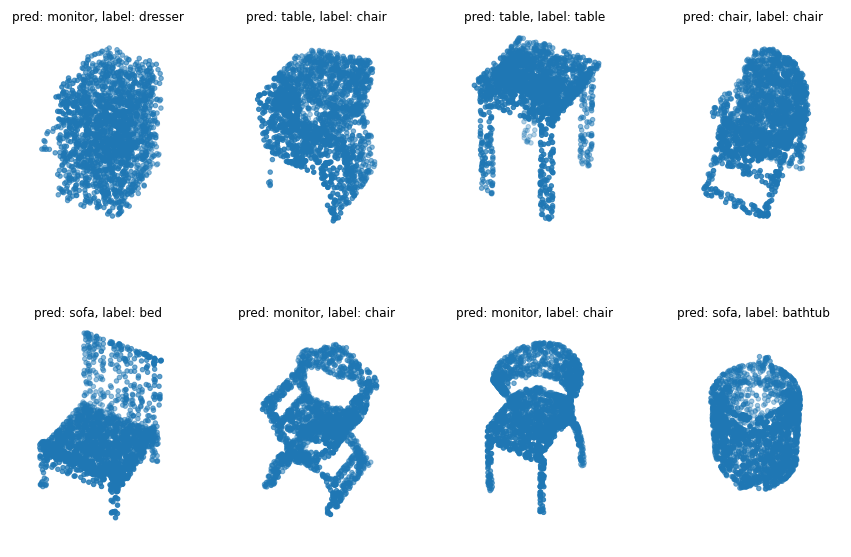

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
#preds = model.predict(points)
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()


In [ ]:
print(test_points.shape)

(908, 2048, 3)


In [ ]:
print(feat_test.shape)

(908, 8)


In [ ]:
print(points.shape)

(8, 2048, 3)


In [ ]:
feat_trainpoints = model_feat2.predict(points)

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


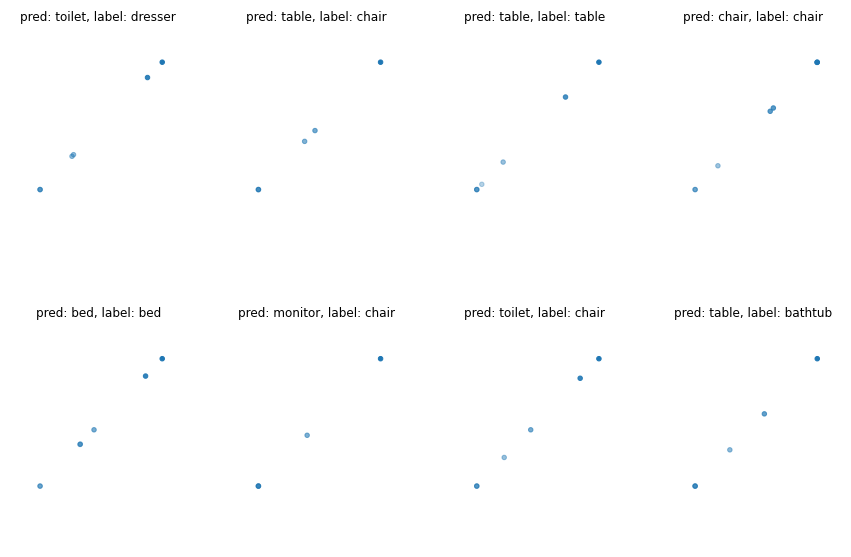

In [ ]:
feat_trainpoints = model_feat2.predict(points)
preds = svm.predict(feat_trainpoints)
preds1 = tf.math.argmax(preds, -1)

#points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    #ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.scatter(feat_trainpoints[i, :], feat_trainpoints[i,  :], feat_trainpoints[i, :])  #, points[i, :, 2]
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i]], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()